In [26]:
import pandas as pd
import numpy as np
import os
from glob import glob
import re
from galvani import BioLogic

from function import read_mpr

import pymysql
from sqlalchemy import create_engine

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.widgets import Slider

from scipy.signal import savgol_filter

# import raw data to MySQL

In [27]:
#load data from folder
ds = read_mpr.mpr_pandas('raw_data')

In [28]:
# list paths of data in .mpr file
datafilespath = glob('raw_data/*.mpr') 
datafilespath =  [os.path.basename(x) for x in datafilespath]

In [25]:
datafilespath

['Cell001_Form_20uA_25T_30RH_Cycle1to10_01_GEIS_CA1.mpr',
 'Cell001_Form_20uA_25T_30RH_Cycle1to10_02_GCPL_CA1.mpr',
 'Cell001_Form_20uA_25T_30RH_Cycle1to10_03_GEIS_CA1.mpr',
 'Cell001_Form_20uA_25T_30RH_Cycle1to10_04_GCPL_CA1.mpr',
 'Cell002_Form_20uA_25T_30RH_Cycle1to10_01_GEIS_CA2.mpr',
 'Cell002_Form_20uA_25T_30RH_Cycle1to10_02_GCPL_CA2.mpr',
 'Cell002_Form_20uA_25T_30RH_Cycle1to10_03_GEIS_CA2.mpr',
 'Cell002_Form_20uA_25T_30RH_Cycle1to10_04_GCPL_CA2.mpr',
 'Cell003_Form_50uA_25T_30RH_Cycle1to10_01_GEIS_CA3.mpr',
 'Cell003_Form_50uA_25T_30RH_Cycle1to10_02_GCPL_CA3.mpr',
 'Cell003_Form_50uA_25T_30RH_Cycle1to10_03_GEIS_CA3.mpr',
 'Cell003_Form_50uA_25T_30RH_Cycle1to10_04_GCPL_CA3.mpr',
 'Cell004_Form_50uA_25T_30RH_Cycle1to10_01_GEIS_CA4.mpr',
 'Cell004_Form_50uA_25T_30RH_Cycle1to10_02_GCPL_CA4.mpr',
 'Cell004_Form_50uA_25T_30RH_Cycle1to10_03_GEIS_CA4.mpr',
 'Cell004_Form_50uA_25T_30RH_Cycle1to10_04_GCPL_CA4.mpr',
 'Cell005_Form_100uA_25T_30RH_Cycle1to10_01_GEIS_CA5.mpr',
 'Cell005_For

In [84]:
ds[0]

,freq/Hz,Re(Z)/Ohm,-Im(Z)/Ohm,|Z|/Ohm,Phase(Z)/deg,time/s,Ewe/V,I/mA,Cs/µF,Cp/µF,cycle number,|Ewe|/V,|I|/A,I Range
0,10001.000000,20.116896,672.406189,672.707031,-88.286346,6.338000e+00,0.004219,-0.001763,0.023667,0.023646,0.0,0.003154,0.000005,117
1,6740.000000,576.129150,936.676025,1099.675781,-58.405228,1.260800e+01,0.003156,-0.003312,0.025210,0.018290,0.0,0.005320,0.000005,117
2,4541.999512,780.680786,1205.806519,1436.465088,-57.079586,1.887400e+01,0.009140,0.000473,0.029060,0.020477,0.0,0.007004,0.000005,117
3,3061.000977,1052.983398,1524.199707,1852.554688,-55.361599,2.513600e+01,0.007566,-0.002180,0.034113,0.023092,0.0,0.009089,0.000005,117
4,2063.000488,1414.236328,1897.714111,2366.724121,-53.305363,3.139800e+01,0.012290,0.000498,0.040653,0.026137,0.0,0.011646,0.000005,117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,0.048894,770.386292,202.271820,796.497925,-14.711464,1.521744e+06,0.006463,-0.004694,16092.566406,1037.831299,0.0,0.003786,0.000005,117
248,0.032596,815.152344,227.076492,846.189758,-15.566210,1.521897e+06,0.006227,-0.004714,21502.044922,1548.419434,0.0,0.003998,0.000005,117
249,0.020955,883.018860,262.406891,921.183838,-16.550381,1.522124e+06,0.010834,-0.001039,28944.248047,2348.659912,0.0,0.004320,0.000005,117
250,0.013970,929.101868,294.240906,974.580933,-17.572678,1.522461e+06,0.014889,0.004695,38719.140625,3529.360107,0.0,0.004602,0.000005,117


In [24]:
##structure 1
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'

Connection = pymysql.connect(host=dbhost,
                          port=dbport,
                          user=dbuser,
                          password =dbpassword)
print('connection succeed')


cursor = Connection.cursor()
cursor.execute('DROP DATABASE IF EXISTS cell_configuration;')
cursor.execute('CREATE DATABASE cell_configuration;')

##cell configuration
engine =create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=dbhost, db='cell_configuration', user=dbuser, pw=dbpassword))
read_mpr.filename_read(datafilespath).to_sql('cell_configuration', engine, if_exists='fail',index=False)
print('table cell_configuration created')

Cell_ID = np.unique([x.split('_')[0] for x in datafilespath])
Unique_Index = np.append(np.unique([x.split('_')[0] for x in datafilespath],return_index=True)[1],len(ds))
Tech_Type = [x.split('_')[-2].lower() for x in datafilespath]

##labor data
for i in range(len(Cell_ID)):
    cursor.execute('DROP DATABASE IF EXISTS '+Cell_ID[i])
    cursor.execute('CREATE DATABASE '+Cell_ID[i])
    engine =create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=dbhost, db=Cell_ID[i], user=dbuser, pw=dbpassword))
    step_ID = [x.split('_')[-3] for x in datafilespath]
    for j in range(Unique_Index[i],Unique_Index[i+1]):
        ds[j].to_sql('step'+step_ID[j]+'_'+Tech_Type[j], engine, if_exists='fail',index=False)
        print('table '+'step'+step_ID[j]+'_'+Tech_Type[j]+' of '+Cell_ID[i]+' created')
        
print('All data loaded')


connection succeed
table cell_configuration created
table step01_geis of Cell001 created
table step02_gcpl of Cell001 created
table step03_geis of Cell001 created
table step04_gcpl of Cell001 created
table step01_geis of Cell002 created
table step02_gcpl of Cell002 created
table step03_geis of Cell002 created
table step04_gcpl of Cell002 created
table step01_geis of Cell003 created
table step02_gcpl of Cell003 created
table step03_geis of Cell003 created
table step04_gcpl of Cell003 created
table step01_geis of Cell004 created
table step02_gcpl of Cell004 created
table step03_geis of Cell004 created
table step04_gcpl of Cell004 created
table step01_geis of Cell005 created
table step02_gcpl of Cell005 created
table step03_geis of Cell005 created
table step04_gcpl of Cell005 created
table step01_geis of Cell006 created
table step02_gcpl of Cell006 created
table step03_geis of Cell006 created
table step04_gcpl of Cell006 created
table step01_geis of Cell007 created
table step02_gcpl of Ce

In [17]:
#structure 2
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'

Connection = pymysql.connect(host=dbhost,
                          port=dbport,
                          user=dbuser,
                          password =dbpassword)
print('connection succeed')


cursor = Connection.cursor()
cursor.execute('DROP DATABASE IF EXISTS cell_configuration;')
cursor.execute('CREATE DATABASE cell_configuration;')

##cell configuration
engine =create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=dbhost, db='cell_configuration', user=dbuser, pw=dbpassword))
read_mpr.filename_read(datafilespath).to_sql('cell_configuration', engine, if_exists='fail',index=False)
print('table cell_configuration created')

Cell_ID = np.unique([x.split('_')[0] for x in datafilespath])
Unique_Index = np.append(np.unique([x.split('_')[0] for x in datafilespath],return_index=True)[1],len(ds))
Tech_Type = [x.split('_')[-2].lower() for x in datafilespath]

##labor data
for i in range(len(Cell_ID)):
    cursor.execute('DROP DATABASE IF EXISTS '+Cell_ID[i])
    cursor.execute('CREATE DATABASE '+Cell_ID[i])
    engine =create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=dbhost, db=Cell_ID[i], user=dbuser, pw=dbpassword))
    step_ID = [x.split('_')[-3] for x in datafilespath]
    
    geis_data_index=[]
    for j in range(Unique_Index[i],Unique_Index[i+1]):
        if j in np.where(np.array(Tech_Type)== 'geis')[0]:
            geis_data_index = np.append(geis_data_index,j)
    geis_data = pd.concat([ds[int(k)] for k in geis_data_index],ignore_index=True)
    geis_data.to_sql('geis', engine, if_exists='fail',index=False)
    print('geis data of '+Cell_ID[i]+ ' loaded')
    
    gcpl_data_index=[]
    for j in range(Unique_Index[i],Unique_Index[i+1]):
        if j in np.where(np.array(Tech_Type)== 'gcpl')[0]:
            gcpl_data_index = np.append(gcpl_data_index,j)
    gcpl_data = pd.concat([ds[int(k)] for k in gcpl_data_index],ignore_index=True)
    gcpl_data.to_sql('gcpl', engine, if_exists='fail',index=False)    
    print('gcpl data of '+Cell_ID[i]+ ' loaded')    

        
print('All data loaded')


connection succeed
table cell_configuration created
geis data of Cell001 loaded
gcpl data of Cell001 loaded
geis data of Cell002 loaded
gcpl data of Cell002 loaded
geis data of Cell003 loaded
gcpl data of Cell003 loaded
geis data of Cell004 loaded
gcpl data of Cell004 loaded
geis data of Cell005 loaded
gcpl data of Cell005 loaded
geis data of Cell006 loaded
gcpl data of Cell006 loaded
geis data of Cell007 loaded
gcpl data of Cell007 loaded
geis data of Cell008 loaded
gcpl data of Cell008 loaded
All data loaded


# Savitzky-Golay filter

## charge/discharge curve

In [85]:
# query data from MySQL
##cell001, gcpl, structure 1
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'
db='cell001'

Connection = pymysql.connect(host=dbhost,
                          port=dbport,
                          user=dbuser,
                          password =dbpassword,
                          database=db)
## charge step
sql = 'SELECT `(Q-Qo)/mA.h`,`Ewe/V`, `time/s` from step02_gcpl'
cursor = Connection.cursor()
cursor.execute(sql)

charge = cursor.fetchall()
charge = np.array(charge)
##discharge step
sql = 'SELECT `(Q-Qo)/mA.h`,`Ewe/V`, `time/s` from step04_gcpl'
cursor.execute(sql)

discharge = cursor.fetchall()
discharge = np.array(discharge)

<IPython.core.display.Javascript object>


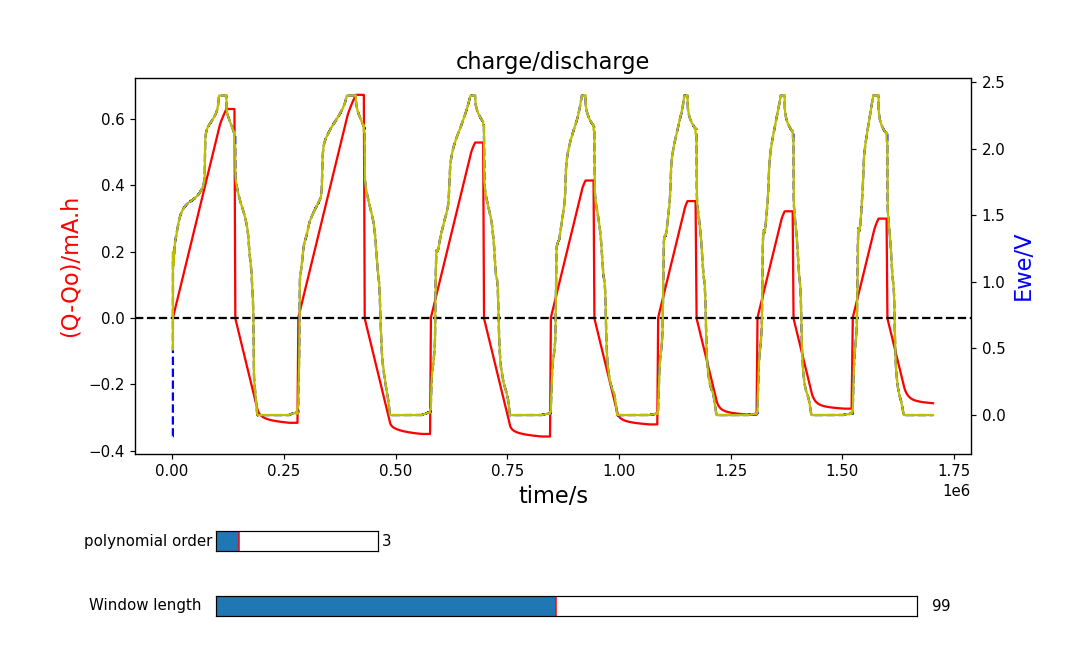

In [92]:
curve=np.concatenate((charge,discharge))
curve=curve[curve[:, 2].argsort()]
%matplotlib notebook
## plot curves
fig,ax = plt.subplots(figsize=(10,6))
plt.subplots_adjust(bottom=0.3)
ax.set_title('charge/discharge',fontsize=15)
ax.plot(curve[:,2], curve[:,0], color="red")
#ax.plot(charge[:,2], charge[:,0], color="red")
#ax.plot(discharge[:,2], -discharge[:,0], color="yellow")
ax.axhline(0,color='black',linestyle='--')
ax.set_xlabel("time/s",fontsize=15)
ax.set_ylabel("(Q-Qo)/mA.h",color="red",fontsize=15)

ax2=ax.twinx()
ax2.plot(E[:,2], E[:,1],"b--")
ax2.set_ylabel("Ewe/V",color="blue",fontsize=15)


p, = ax2.plot(curve[:,2], savgol_filter(curve[:,1],111,3), "y")

## define the slides
ax_slide1 = plt.axes([0.2,0.05,0.65,0.03])
ax_slide2 = plt.axes([0.2,0.15,0.15,0.03])

## properties of slides
win_len = Slider(ax_slide1,'Window length', valmin = 5,valmax = 199,valinit = 99,valstep = 2)
p_order = Slider(ax_slide2,'polynomial order', valmin = 2,valmax = 9,valinit = 3,valstep = 1)

## updating function
def update(val):
    current_win_len = int(win_len.val)
    current_p_order = int(p_order.val)
    p.set_ydata(savgol_filter(curve[:,1],current_win_len,current_p_order))
    fig.canvas.draw()
    
win_len.on_changed(update)
p_order.on_changed(update)

plt.show()
